In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tarfile
import urllib
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
import cPickle as pickle
import tensorflow as tf
import matplotlib.image as mpimg



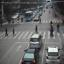

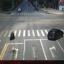

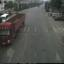

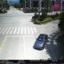

In [2]:
num_classes = 2
from IPython.display import Image,display
listOfImageName=['./image_64/label_64_64_0/361123201502011309E03655_1.JPG',
                './image_64/label_64_64_0/361124201508011107L06095_3.JPG',
                './image_64/label_64_64_1/361125201505011209L55757_3.JPG',
                './image_64/label_64_64_1/361129201504011309EF7139_1.JPG']
for imageName in listOfImageName:
    display(Image(filename=imageName))
    
    

In [3]:
image_size = 64  # Pixel width and height.
channel = 3
pixel_depth = 255.0  # Number of levels per pixel.
folders = ['image_64/label_64_64_0',
            'image_64/label_64_64_1']

def load(data_folders, min_num_images, max_num_images):
  dataset = np.ndarray(
    shape=(max_num_images, image_size, image_size, channel), dtype=np.float32)
  original_dataset = np.ndarray(
    shape=(max_num_images, image_size, image_size, channel), dtype=np.uint8)
  labels = np.ndarray(shape=(max_num_images), dtype=np.int32)
  label_index = 0
  image_index = 0
  for folder in data_folders:
    print folder
    for image in os.listdir(folder):
      if image_index >= max_num_images:
        raise Exception('More images than expected: %d >= %d' % (
          num_images, max_num_images))
      image_file = os.path.join(folder, image)
      try:
        original_data = mpimg.imread(image_file)
        image_data = (ndimage.imread(image_file).astype(float) -
                      pixel_depth / 2) / pixel_depth
        if image_data.shape != (image_size, image_size,channel):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[image_index, :, :, :] = image_data
        original_dataset[image_index, :, :, :] = original_data
        labels[image_index] = label_index
        image_index += 1
      except IOError as e:
        print 'Could not read:', image_file, ':', e, '- it\'s ok, skipping.'
    label_index += 1
  num_images = image_index
  dataset = dataset[0:num_images, :, :, :]
  original_dataset = original_dataset[0:num_images, :, :, :]
  labels = labels[0:num_images]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' % (
        num_images, min_num_images))
  print 'Full dataset tensor:', dataset.shape
  print 'Full original dataset tensor:', original_dataset.shape
  print 'Mean:', np.mean(dataset)
  print 'Standard deviation:', np.std(dataset)
  print 'Labels:', labels.shape
  return original_dataset,dataset, labels
original_dataset,dataset, labels = load(folders, 5000, 6000)

image_64/label_64_64_0
image_64/label_64_64_1
Full dataset tensor: (5564, 64, 64, 3)
Full original dataset tensor: (5564, 64, 64, 3)
Mean: -0.174343
Standard deviation: 0.209329
Labels: (5564,)


In [4]:
np.random.seed(133)
def randomize(original_dataset,dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_original_dataset = original_dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_original_dataset,shuffled_dataset, shuffled_labels
original_dataset,dataset, labels = randomize(original_dataset,dataset, labels)

In [5]:
train_size = 4500
valid_size = 500
test_size = 500

valid_dataset = dataset[:valid_size,:,:,:]
valid_labels = labels[:valid_size]
train_dataset = dataset[valid_size:valid_size+train_size,:,:,:]
train_labels = labels[valid_size:valid_size+train_size]
test_dataset = dataset[valid_size+train_size:train_size+valid_size+test_size,:,:,:]
test_labels = labels[valid_size+train_size:train_size+valid_size+test_size]

original_valid_dataset = original_dataset[:valid_size,:,:,:]
original_train_dataset = original_dataset[valid_size:valid_size+train_size,:,:,:]
original_test_dataset = original_dataset[valid_size+train_size:train_size+valid_size+test_size,:,:,:]


print 'Training', train_dataset.shape, train_labels.shape
print 'Validation', valid_dataset.shape, valid_labels.shape
print 'Test', test_dataset.shape, test_labels.shape
print 'original_Training', original_train_dataset.shape
print 'original_Validation', original_valid_dataset.shape
print 'original_Test', original_test_dataset.shape

Training (4500, 64, 64, 3) (4500,)
Validation (500, 64, 64, 3) (500,)
Test (500, 64, 64, 3) (500,)
original_Training (4500, 64, 64, 3)
original_Validation (500, 64, 64, 3)
original_Test (500, 64, 64, 3)


In [7]:
image_size = 64
num_labels = 2
num_channels = 3 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print 'Training set', train_dataset.shape, train_labels.shape
print 'Validation set', valid_dataset.shape, valid_labels.shape
print 'Test set', test_dataset.shape, test_labels.shape

Training set (4500, 64, 64, 3) (4500, 2)
Validation set (500, 64, 64, 3) (500, 2)
Test set (500, 64, 64, 3) (500, 2)


In [8]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [9]:
batch_size = 50
patch_size = 5
depth = 16
num_hidden = 512
lamada = 0.02
graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  conv1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  conv1_biases = tf.Variable(tf.zeros([depth]))
  conv2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth*2], stddev=0.1))
  conv2_biases = tf.Variable(tf.constant(0.0, shape=[depth*2]))
  conv3_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth*2, depth*4], stddev=0.1))
  conv3_biases = tf.Variable(tf.constant(0.0, shape=[depth*4]))
  conv4_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth*4, depth*8], stddev=0.1))
  conv4_biases = tf.Variable(tf.constant(1.0, shape=[depth*8]))


  full_weights = tf.Variable(tf.truncated_normal(
      [image_size / 16 * image_size / 16 * depth*8, num_hidden], stddev=0.1))
  full_biases = tf.Variable(tf.constant(0.0, shape=[num_hidden]))
  softmax_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  softmax_biases = tf.Variable(tf.constant(0.0, shape=[num_labels]))

  # Dropout.
  keep_prob = tf.placeholder("float")
  
  # Model.
  def model(data):
    conv_1 = tf.nn.conv2d(data, conv1_weights, [1, 1, 1, 1], padding='SAME')
    relu_1 = tf.nn.relu(conv_1 + conv1_biases)
    max_pool_1 = tf.nn.max_pool(relu_1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1],padding = 'SAME')
    
    conv_2 = tf.nn.conv2d(max_pool_1, conv2_weights, [1, 1, 1, 1], padding='SAME')
    relu_2 = tf.nn.relu(conv_2 + conv2_biases)
    max_pool_2 = tf.nn.max_pool(relu_2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1],padding = 'SAME')
    
    conv_3 = tf.nn.conv2d(max_pool_2, conv3_weights, [1, 1, 1, 1], padding='SAME')
    relu_3 = tf.nn.relu(conv_3 + conv3_biases)
    max_pool_3 = tf.nn.max_pool(relu_3, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1],padding = 'SAME')
    
    conv_4 = tf.nn.conv2d(max_pool_3, conv4_weights, [1, 1, 1, 1], padding='SAME')
    relu_4 = tf.nn.relu(conv_4 + conv4_biases)
    max_pool_4 = tf.nn.max_pool(relu_4, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1],padding = 'SAME')
    
    shape = max_pool_4.get_shape().as_list()
    reshape = tf.reshape(max_pool_4, [shape[0], shape[1] * shape[2] * shape[3]])
    full_layer = tf.nn.relu(tf.matmul(reshape, full_weights) + full_biases)
    softmax_layer = tf.nn.dropout(full_layer, keep_prob)
    return tf.matmul(softmax_layer, softmax_weights) + softmax_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
     
  loss = tf.reduce_mean(
     tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + 
     lamada*(tf.nn.l2_loss(conv1_weights) + tf.nn.l2_loss(conv2_weights) + 
          tf.nn.l2_loss(conv3_weights) + tf.nn.l2_loss(conv4_weights) + 
          tf.nn.l2_loss(full_weights) + tf.nn.l2_loss(softmax_weights) ))

  optimizer = tf.train.GradientDescentOptimizer(0.02).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))
  saver = tf.train.Saver()

In [34]:
def accuracy2(predictions, labels):
    TURE_FALSE = np.argmax(predictions, 1) == np.argmax(labels, 1)
    predictions = np.argmax(predictions, 1)
    labels = np.argmax(labels, 1)
    accuracy = (100.0 * np.sum(TURE_FALSE / predictions.shape[0]))
    return TURE_FALSE, predictions, labels,accuracy

In [35]:
num_steps = 0

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  saver.restore(session,'conv_layer4_param4-5000')
  print "Initialized"
  for step in xrange(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,keep_prob : 0.5}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print "Minibatch loss at step", step, ":", l
      print "Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)
      print "Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(feed_dict={keep_prob : 1}), valid_labels)
    #if (step % 5000 == 0):
        #saver.save(session,'conv_layer4_param4',global_step = step)
  TRUE_FALSE, predictions, labels, accuracy = accuracy2(test_prediction.eval(feed_dict={keep_prob : 1}), test_labels)
  print "Test accuracy: %.1f%%" % accuracy

# 第一次 训练5000次 Test accuracy 为 87.6%
# 第二次 加训10000次 Test accuracy 为 89.6%
# 第三次 由于之前有过拟合现象,采用参数regularization. 训练了 5000次 84.2%
# 第四次 继续加训5000次 达到 85.6% Minibatch 降到 0.592821 说明没有过拟合
# 下面需要对模型进行改进,增加层数.才能提高准确率.
# 用四层的conv 获得 accuracy 89.8% Minibatch 的接受度 接近100% 可能还是过拟合,或者测试数据集 有问题

Initialized
Test accuracy: 0.0%


In [43]:
# print TRUE_FALSE
flag = 0
for status in TRUE_FALSE:
    if status == False :
       print(flag )
    flag = flag + 1

5
14
28
41
57
63
75
76
78
84
85
105
114
125
132
145
170
186
207
208
219
226
230
233
288
292
293
301
310
311
325
339
349
367
378
379
384
386
387
388
394
396
417
422
432
437
446
467
492
496


False
1
0


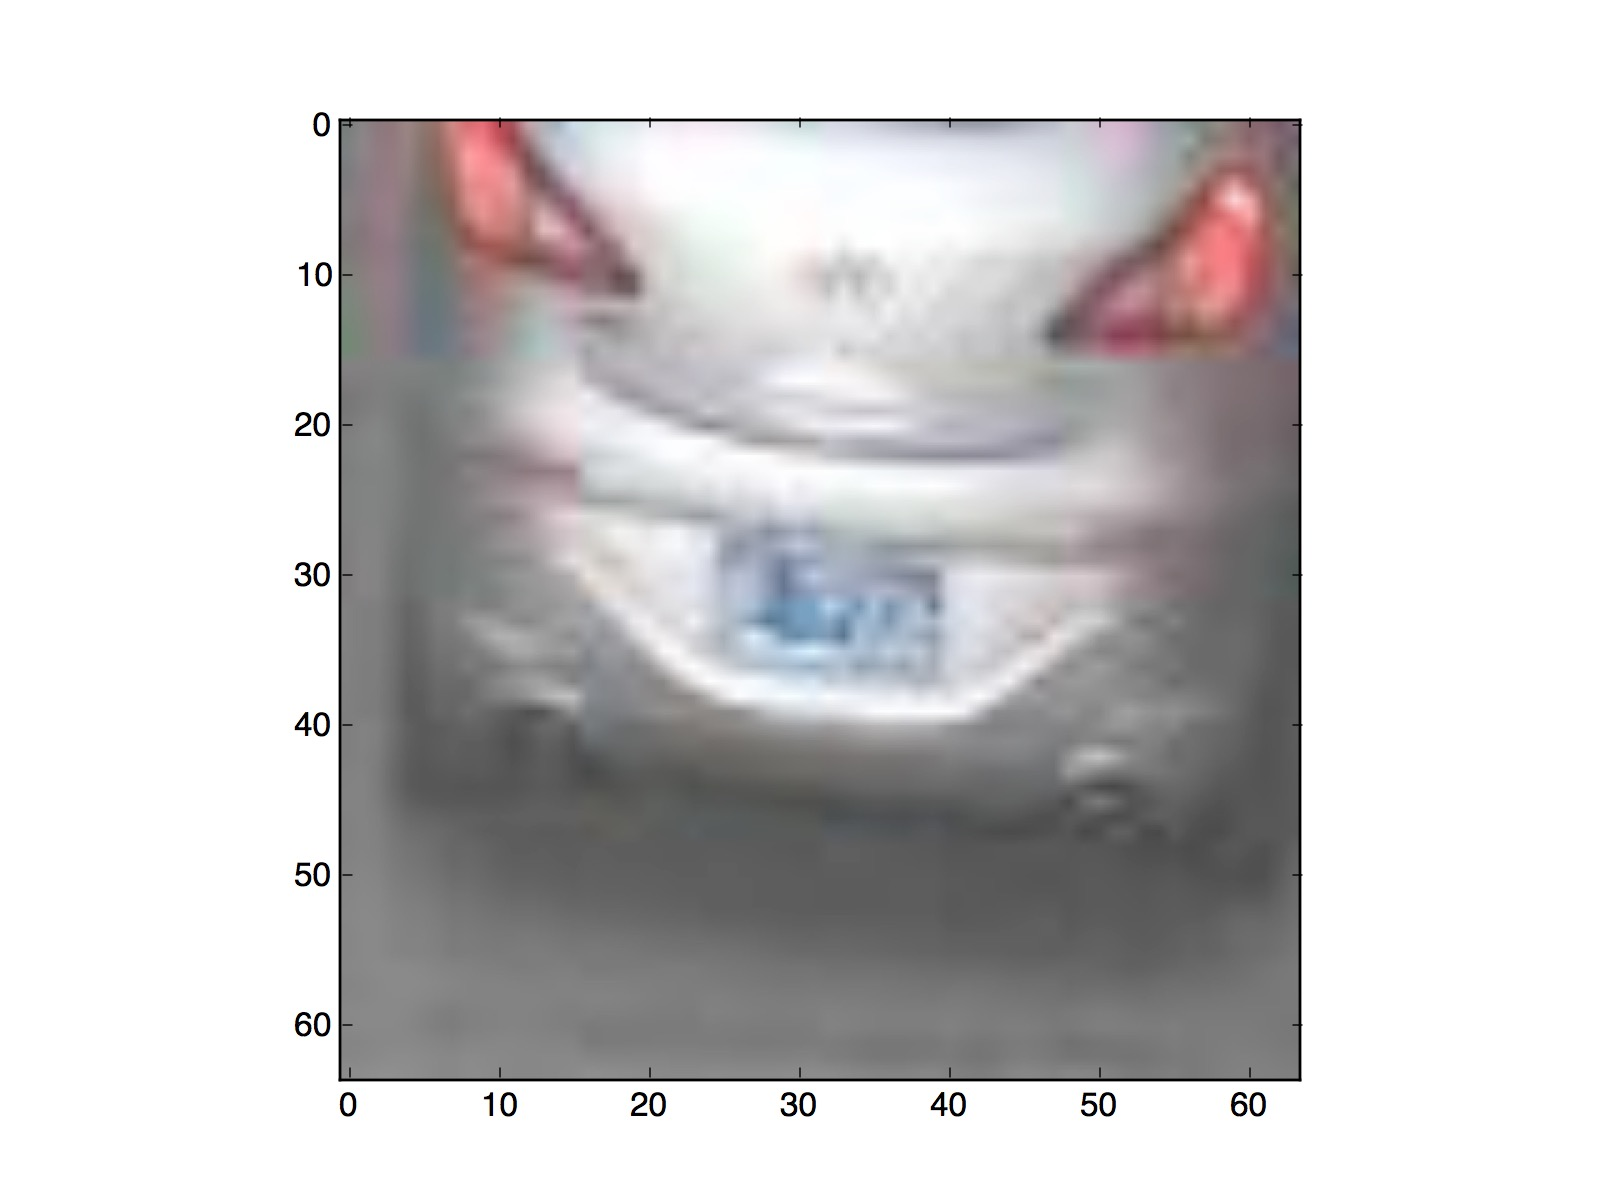

In [46]:
i = 57
img = original_test_dataset[i,:,:,:]

print TRUE_FALSE[i]
print predictions[i]
print labels[i]
plt.imshow(img)
plt.savefig('temp.jpg')
Image(filename='temp.jpg')